In [1]:
import numpy as np
import cv2
import h5py
from scipy import stats

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
with h5py.File('../data/hvacmon_data.h5', 'r') as f:
    im = f['/annotated/2019-02-22T11-58-27'][:]

#im = cv2.imread("c:/users/sean/scratch/snapshots/2019_02_28_snapshot/2019-02-27T19-03-16_2019-02-27T19-03-21.png")

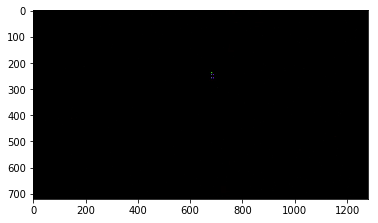

In [3]:
plt.imshow(im)

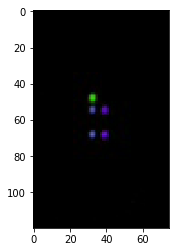

In [4]:
#
# Crop an ROI -- hardcode for now!
#
im_roi = im[190:310,650:725]
plt.imshow(im_roi)

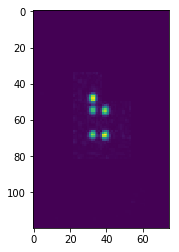

In [5]:
im_hsv = cv2.cvtColor(im_roi, cv2.COLOR_BGR2HSV)
plt.imshow(im_hsv[:,:,2])

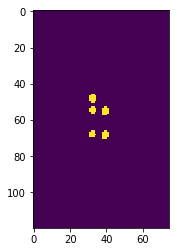

In [6]:
mask = (im_hsv[:,:,2] > 75).astype(np.uint8)*255
plt.imshow(mask)

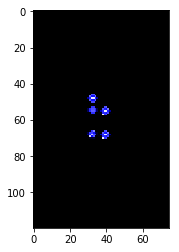

In [7]:
params = cv2.SimpleBlobDetector_Params()
params.minThreshold = 0
params.maxThreshold = 400
params.minDistBetweenBlobs = 1
params.filterByArea = True
params.minArea = 0
params.maxArea = 25
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False
params.filterByColor = False

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect((mask.astype(np.uint8)))

im_with_keypoints = cv2.drawKeypoints(mask, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(im_with_keypoints)

In [8]:
pts = np.asarray([[p.pt[1], p.pt[0]] for p in keypoints])

In [9]:
green_led_row_idx = np.argmin(pts[:,0])

power_led = pts[green_led_row_idx, :]
power_led

array([48. , 32.5])

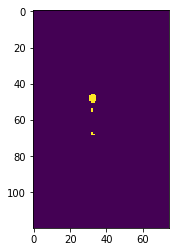

In [12]:
# Sanity check - is the 'power led' actually green?
plt.imshow(im_roi[:,:,1] > 75)

In [13]:
status_leds = np.delete(pts, green_led_row_idx, axis=0)
status_leds

array([[68.07936859, 39.44444275],
       [67.66666412, 32.25640869],
       [55.07936478, 39.44444275],
       [54.5       , 32.5       ]])

In [17]:
led_spacing = (7,7)

# Row offsets
zone_rows_estimated = \
    np.linspace(
        power_led[0] + led_spacing[0],
        power_led[0] + led_spacing[0]*4,
        4)

zone_cols_estimated = \
    np.linspace(
        power_led[1],
        power_led[1] + led_spacing[1],
        2)

In [18]:
status = np.zeros((4,2), dtype=np.uint8)

for led in status_leds:
    zone_row = (np.abs(led[0]-zone_rows_estimated)).argmin()
    zone_col = (np.abs(led[1]-zone_cols_estimated)).argmin()
    status[zone_row, zone_col] = 1
    
print(status)

[[1 1]
 [0 0]
 [1 1]
 [0 0]]
